In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna
import json

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Function to check dataset consistency
def check_data_integrity(df, name="Dataset"):
    print(f"Checking {name} integrity:")
    print("Shape:", df.shape)
    print("Missing values:", df.isnull().sum())
    print("Data types:", df.dtypes)
    print("-" * 40)

# Load training data
df = pd.read_csv("training_data.csv")
df.drop_duplicates(inplace=True)

# Ensure Model Year is not missing
df = df.dropna(subset=["Model Year"]).sort_values(by="Date", ascending=True).reset_index(drop=True)
df["Model Year"] = df["Model Year"].astype(int)

# Drop unnecessary columns
df = df.drop(columns="Region", axis=1)

# Convert categorical columns to category type
categorical_cols = ["Vehicle Category", "Fuel Type", "Fuel Technology", "Electric Mile Range"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

# Encode 'Number of Vehicles Registered at the Same Address'
df["Number of Vehicles Registered at the Same Address"] = df["Number of Vehicles Registered at the Same Address"].replace(
    {'1': 1, '2': 2, '3': 3, "≥4": 4, "Unknown": -1})

# Replace unknown values in 'GVWR Class'
df["GVWR Class"] = df["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

# Check integrity
check_data_integrity(df, "Training Data")

# Split into train and test sets
X = df.drop(columns="Vehicle Population")
y = df["Vehicle Population"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert 'GVWR Class' to categorical codes
X_train["GVWR Class"] = X_train["GVWR Class"].astype("category").cat.codes
X_test["GVWR Class"] = X_test["GVWR Class"].astype("category").cat.codes


Checking Training Data integrity:
Shape: (40450, 9)
Missing values: Date                                                 0
Vehicle Category                                     0
GVWR Class                                           0
Fuel Type                                            0
Model Year                                           0
Fuel Technology                                      0
Electric Mile Range                                  0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
dtype: int64
Data types: Date                                                    int64
Vehicle Category                                     category
GVWR Class                                             object
Fuel Type                                            category
Model Year                                              int64
Fuel Technology                                      category
Electric Mile Range                     

In [2]:
df

,Date,Vehicle Category,GVWR Class,Fuel Type,Model Year,Fuel Technology,Electric Mile Range,Number of Vehicles Registered at the Same Address,Vehicle Population
0,2019,P,-1,Gasoline,2020,ICE,Not Applicable,4,395883
1,2019,T6,7,Diesel,1996,ICE,Not Applicable,1,70
2,2019,T6,7,Diesel,1993,ICE,Not Applicable,1,70
3,2019,T6,6,Diesel,1986,ICE,Not Applicable,4,70
4,2019,T4,-1,Diesel,1992,ICE,Not Applicable,4,70
...,...,...,...,...,...,...,...,...,...
40445,2023,BS,-1,Diesel,1999,ICE,Not Applicable,1,12
40446,2023,B,-1,Diesel,2024,ICE,Not Applicable,1,12
40447,2023,B,-1,Diesel,2019,ICE,Not Applicable,3,12
40448,2023,B,-1,Diesel,2016,ICE,Not Applicable,3,12


In [3]:

# Load cleaned data for scoring
df1 = pd.read_csv("scoring.csv", index_col=0)
df1 = df1.drop(columns="Region", axis=1)

# Convert categorical columns to category type
for col in categorical_cols:
    df1[col] = df1[col].astype("category")

df1["Number of Vehicles Registered at the Same Address"] = df1["Number of Vehicles Registered at the Same Address"].replace(
    {'1': 1, '2': 2, '3': 3, "≥4": 4, "Unknown": -1})

df1["GVWR Class"] = df1["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

# Check integrity
check_data_integrity(df1, "Cleaned Data")

# Separate features and target variable
X_scoring = df1.drop(columns="Vehicle Population", errors="ignore")
y_scoring = df1["Vehicle Population"] if "Vehicle Population" in df1 else None

# Convert 'GVWR Class' to categorical codes
X_scoring["GVWR Class"] = X_scoring["GVWR Class"].astype("category").cat.codes


Checking Cleaned Data integrity:
Shape: (7546, 8)
Missing values: Vehicle Category                                       0
GVWR Class                                             0
Fuel Type                                              0
Model Year                                           106
Fuel Technology                                        0
Electric Mile Range                                    0
Number of Vehicles Registered at the Same Address      0
Vehicle Population                                     0
dtype: int64
Data types: Vehicle Category                                     category
GVWR Class                                             object
Fuel Type                                            category
Model Year                                            float64
Fuel Technology                                      category
Electric Mile Range                                  category
Number of Vehicles Registered at the Same Address       int64
Vehicle Population 

In [4]:
df

,Date,Vehicle Category,GVWR Class,Fuel Type,Model Year,Fuel Technology,Electric Mile Range,Number of Vehicles Registered at the Same Address,Vehicle Population
0,2019,P,-1,Gasoline,2020,ICE,Not Applicable,4,395883
1,2019,T6,7,Diesel,1996,ICE,Not Applicable,1,70
2,2019,T6,7,Diesel,1993,ICE,Not Applicable,1,70
3,2019,T6,6,Diesel,1986,ICE,Not Applicable,4,70
4,2019,T4,-1,Diesel,1992,ICE,Not Applicable,4,70
...,...,...,...,...,...,...,...,...,...
40445,2023,BS,-1,Diesel,1999,ICE,Not Applicable,1,12
40446,2023,B,-1,Diesel,2024,ICE,Not Applicable,1,12
40447,2023,B,-1,Diesel,2019,ICE,Not Applicable,3,12
40448,2023,B,-1,Diesel,2016,ICE,Not Applicable,3,12


In [5]:
df1

,Vehicle Category,GVWR Class,Fuel Type,Model Year,Fuel Technology,Electric Mile Range,Number of Vehicles Registered at the Same Address,Vehicle Population
Date,,,,,,,,
2024,P,-1,Gasoline,2020.0,ICE,Not Applicable,4,316065
2024,P,-1,Gasoline,2021.0,ICE,Not Applicable,4,315986
2024,P,-1,Gasoline,2022.0,ICE,Not Applicable,4,306487
2024,P,-1,Gasoline,2024.0,ICE,Not Applicable,4,284754
2024,P,-1,Gasoline,2023.0,ICE,Not Applicable,4,284153
...,...,...,...,...,...,...,...,...
2024,B,-1,Diesel,1989.0,ICE,Not Applicable,3,1
2024,B,-1,Diesel,1988.0,ICE,Not Applicable,2,1
2024,B,-1,Diesel,1988.0,ICE,Not Applicable,3,1


In [6]:

# Hyperparameter tuning function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'subsample': trial.suggest_uniform('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 2.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 5.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 5.0),
        'random_state': 42
    }

    encoder = TargetEncoder(cols=categorical_cols)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    X_train_encoded[categorical_cols] = encoder.fit_transform(X_train[categorical_cols], y_train)
    X_test_encoded[categorical_cols] = encoder.transform(X_test[categorical_cols])

    model = XGBRegressor(**params)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Run Optuna tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)


[I 2025-02-02 03:19:52,454] A new study created in memory with name: no-name-7cede4e3-24aa-40c1-9d71-f13463e0054b
[I 2025-02-02 03:19:52,829] Trial 0 finished with value: 8657.04106493668 and parameters: {'max_depth': 4, 'learning_rate': 0.014829799521004135, 'n_estimators': 430, 'subsample': 0.8936746297331616, 'colsample_bytree': 0.7475386976087901, 'reg_alpha': 0.7219912897294153, 'reg_lambda': 2.0592200052322833, 'gamma': 1.9971868531152892}. Best is trial 0 with value: 8657.04106493668.
[I 2025-02-02 03:19:53,562] Trial 1 finished with value: 7205.290001103356 and parameters: {'max_depth': 8, 'learning_rate': 0.01121432553497297, 'n_estimators': 466, 'subsample': 0.6809640715124338, 'colsample_bytree': 0.6561211310584877, 'reg_alpha': 0.29291821210454344, 'reg_lambda': 1.1494022763794072, 'gamma': 1.2047722908175857}. Best is trial 1 with value: 7205.290001103356.
[I 2025-02-02 03:19:54,340] Trial 2 finished with value: 3936.5233391915767 and parameters: {'max_depth': 8, 'learning

In [7]:

# Save best hyperparameters
top_trials = sorted(study.trials, key=lambda x: x.value)[:3]
top_params = [trial.params for trial in top_trials]

with open("best_models.json", "w") as f:
    json.dump(top_params, f, indent=4)

print("Best parameters saved successfully.")


Best parameters saved successfully.


In [8]:

# Load best models and apply to scoring dataset
with open("best_models.json", "r") as f:
    best_params = json.load(f)

# Ensure categorical encoding is consistent
encoder = TargetEncoder(cols=categorical_cols)
X_train_encoded = X_train.copy()
X_train_encoded[categorical_cols] = encoder.fit_transform(X_train[categorical_cols], y_train)
scoring_encoded = X_scoring.copy()
scoring_encoded[categorical_cols] = encoder.transform(X_scoring[categorical_cols])

# Predict with best models
predictions = {}
rmse_scores = {}

for i, params in enumerate(best_params):
    model = XGBRegressor(**params)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(scoring_encoded)
    predictions[f"Model_{i+1}"] = y_pred

    if y_scoring is not None:
        rmse = np.sqrt(mean_squared_error(y_scoring, y_pred))
        rmse_scores[f"Model_{i+1}"] = rmse
        print(f"Model {i+1} RMSE: {rmse}")

# Save predictions
pd.DataFrame(predictions).to_csv("predictions.csv", index=False)
print("Predictions saved successfully.")


ValueError: feature_names mismatch: ['Date', 'Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address'] ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address']
expected Date in input data

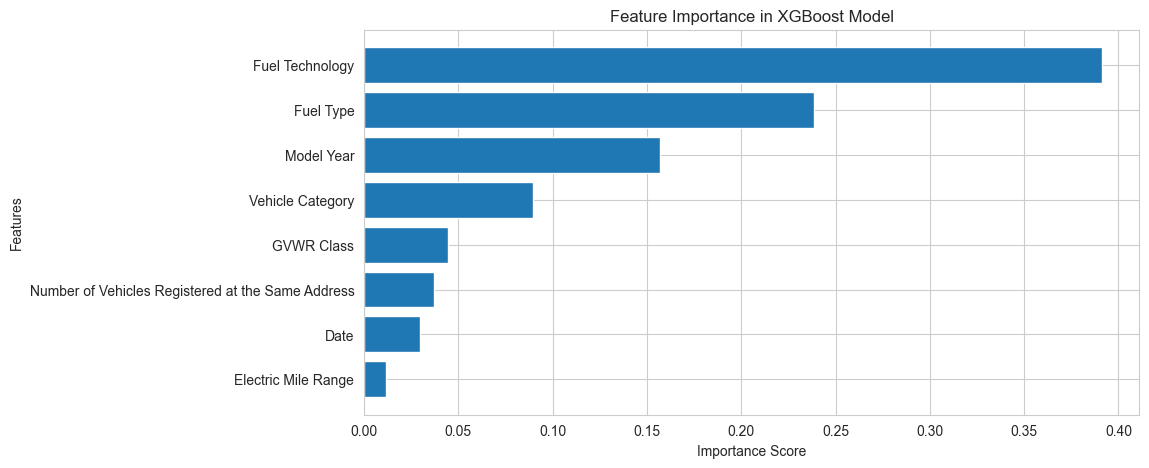

                                             Feature  Importance
5                                    Fuel Technology    0.391356
3                                          Fuel Type    0.238741
4                                         Model Year    0.157169
1                                   Vehicle Category    0.089454
2                                         GVWR Class    0.044783
7  Number of Vehicles Registered at the Same Address    0.036996
0                                               Date    0.029815
6                                Electric Mile Range    0.011687


In [15]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Train the model (ensure best_params is defined)
best_model = xgb.XGBRegressor(**best_params[0])
best_model.fit(X_train_encoded, y_train)

# Get feature importance
feature_importance = best_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # Flip the order
plt.show()

# Print top features
print(importance_df)


In [19]:
# Create a DataFrame to compare y_test and y_pred
comparison_df = pd.DataFrame({
    'Actual': y_scoring,
    'Predicted': y_pred
})
pre = pd.DataFrame(comparison_df)
pre.to_csv('comparison.csv', index=False)
# Display the DataFrame
print(comparison_df.head(50))


    Actual      Predicted
0   395883  365326.375000
1       70      57.511814
2       70      71.474434
3       70     141.471893
4       70     284.990936
5       70     252.631622
6       70     359.889587
7       70     168.522141
8       70     397.395752
9       69     361.834503
10      69      79.976524
11      70      34.719074
12      69      97.658737
13      69    -461.560974
14      69    -215.159134
15      69    -486.035217
16      69     435.532288
17      69      22.378340
18      69     102.208588
19      69      32.714355
20      69     370.172638
21      69    -142.333557
22      69    -915.480408
23      69     369.469360
24      69    -658.723511
25      70      75.115044
26      70      19.513519
27      72     109.789444
28      72     225.811142
29      72    -184.448578
30      71     -96.160995
31      71      -6.157293
32      71     330.209137
33      71     130.874481
34      71      36.768318
35      71    -125.343826
36      71    -309.598724
37      70  

In [17]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from category_encoders import TargetEncoder

# Ensure categorical encoding is consistent
encoder = TargetEncoder(cols=categorical_cols)
X_train_encoded = X_train.copy()
X_train_encoded[categorical_cols] = encoder.fit_transform(X_train[categorical_cols], y_train)

# Convert dataset into XGBoost's DMatrix format (improves efficiency)
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)

# Define K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform XGBoost cross-validation
cv_results = xgb.cv(
    best_params[0],  # Ensure this is a dictionary
    dtrain,
    num_boost_round=500,
    folds=kf,
    metrics="rmse",  # ✅ Correct metric for regression
    as_pandas=True,
    early_stopping_rounds=50,
    seed=42
)

# Print mean and standard deviation of RMSE across folds
mean_rmse = cv_results["test-rmse-mean"].iloc[-1]
std_rmse = cv_results["test-rmse-std"].iloc[-1]

print(f"Mean RMSE across folds: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

# Detect overfitting
if std_rmse > mean_rmse * 0.2:
    print("⚠️ Possible overfitting detected: High RMSE variance across folds!")
else:
    print("✅ Model appears to generalize well across folds.")

# Train the best model using full dataset
model = xgb.train(best_params[0], dtrain, num_boost_round=500)

# Predict on training data
y_train_pred = model.predict(dtrain)

# Compute RMSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse:.4f}")

# Compare training and validation RMSE
if train_rmse < mean_rmse * 0.9:  # If training RMSE is much lower than validation RMSE
    print("⚠️ Possible overfitting detected: Training RMSE is significantly lower than validation RMSE!")
else:
    print("✅ Training and validation RMSE are consistent.")


Mean RMSE across folds: 4110.6926
Standard Deviation of RMSE: 578.6689
✅ Model appears to generalize well across folds.
Training RMSE: 535.0620
⚠️ Possible overfitting detected: Training RMSE is significantly lower than validation RMSE!


In [18]:
# Save predictions to a separate CSV file
predictions_df = pd.DataFrame(y_scoring, y_pred)
predictions_df.to_csv("model_predictions.csv", index=False)
print("Predictions exported to 'model_predictions.csv' successfully.")

# Load the predictions from CSV
predictions_loaded = pd.read_csv("model_predictions.csv")

# Calculate RMSE for each model
rmse_comparison = {}
for i, col in enumerate(predictions_loaded.columns):
    rmse = np.sqrt(mean_squared_error(y_scoring, predictions_loaded[col]))
    rmse_comparison[col] = rmse
    print(f"{col} RMSE: {rmse:.4f}")

# Save RMSE comparison results
rmse_df = pd.DataFrame(list(rmse_comparison.items()), columns=["Model", "RMSE"])
rmse_df.to_csv("rmse_comparison.csv", index=False)
print("RMSE results saved to 'rmse_comparison.csv'.")

# Display RMSE values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(rmse_df["Model"], rmse_df["RMSE"])
plt.xlabel("RMSE Score")
plt.ylabel("Models")
plt.title("Comparison of Model RMSE Scores")
plt.gca().invert_yaxis()
plt.show()

# Print RMSE dataframe for reference
from IPython.display import display

display(rmse_df)


Predictions exported to 'model_predictions.csv' successfully.


ValueError: Input contains NaN.